Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

This tutorial demonstrates how the covid and economic simulation can be used to simulate different health and economic policies during the COVID-19 pandemic in the US and to study their effect on social objectives that combine public health and economic productivity.

We begin with a brief introduction to the problem and then show how we implement it in simulation.  

For further reading, check out our [paper](https://arxiv.org/abs/2108.02904), [web demo](https://einstein.ai/the-ai-economist/ai-policy-foundation-and-covid-case-study), and [blog post](https://blog.einstein.ai/ai-economist-covid-case-study-ethics ).

# Introduction

The COVID-19 and economic simulation environment studies the effect of health and economic governmental policies on the spread of the COVID-19 pandemic and the economy, and captures the tradeoffs therein. It is built on top of our economic simulation framework [Foundation](https://github.com/salesforce/ai-economist). The environment comprises 52 entities overall, including 51 state governors (agents) - one each for the 50 US states and the District of Columbia, and the federal government (planner).

In our simulation, the US state governors determine the stringency levels (which represents a combination of several containment and closure policies), while the federal government determines how much to subsidize each of the US states (via relief payments). Notably, this set of actions captures several interesting health-economy tradeoffs. For instance,
- If the states shut down more, there will be fewer cases and deaths, but the unemployment rate also increases, hurting the economy.
- If the federal government subsidizes more, it helps alleviate the economy of the US states, and, in turn, incentivizes them to shut down more in order to bring down the cases and deaths. However the federal government needs to borrow the subsidy money at a certain interest rate, and the cost of borrowing lowers its economic index, as does the lost economic output resulting from the additional shut downs.

Each of the states and the federal government try to balance public health and the economy in order to improve **social welfare**.

## Social Welfare

Social welfare is a (weighted) combination of the health index $H$ and the economic index $E$:
$$SW = \alpha H + (1-\alpha)E.$$
$\alpha$ is a weighting term ($0 \leq \alpha \leq 1$). By varying $\alpha$, we can define a family of social welfare functions that prioritize between the health and the economy, ranging from focusing fully on economy ($\alpha=0$) to fully on health ($\alpha=1$).

The health index $H$ is proportional to the negative of COVID-19-related deaths: fewer the deaths, higher is the health index. The economic index $E$ is a function of the annual GDP, unemployment and federal subsidies; so higher GDP implies a higher economic index and vice versa. For more mathematical details on $H$, $E$ and $SW$, please see our [paper](https://arxiv.org/abs/2108.02904)

Our simulation can be used to study the effects of various US state and federal government policies on COVID-19 deaths, unemployment and the economy, and can be used in conjunction with reinforcement learning to optimize the policies for varying definitions of social welfare.

## Dependencies

You can install the ai-economist package using the pip package manager:

In [3]:
import os, signal, sys, time
!pip install ai-economist

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from ai_economist import foundation
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

# Set font size for the matplotlib figures
plt.rcParams.update({'font.size': 26})

### In order to download and use the latest COVID-19 data in our economic simulation, please run the following notebooks in "ai_economist/datasets/covid19_datasets".

1. gather_real_world_data.ipynb
2. fit_model_parameters.ipynb

Upon running these notebooks, you will fetch the latest real-world data, and use the data to fit models that will be used in the COVID-19 and economy simulation. From the notebooks, you will need to record the "path_to_data_and_fitted_params" to set into the environment config below

Note: If you do not wish to download the real-world data, you can still run this notebook as is, and it will use the data saved in the ai_economist/datasets/covid19_datasets/path_to_data_and_fitted_params directory.

# Creating a simulation environment

To create the covid-19 and economic simulation, we first define the configuration of the environment that will be built.

In [5]:
env_config = {
    # Scenario name - determines which scenario class to use
    "scenario_name": "CovidAndEconomySimulation",
    
    # The list of components in this simulation
    "components": [
        {"ControlUSStateOpenCloseStatus": {
            # action cooldown period in days.
            # Once a stringency level is set, the state(s) cannot switch to another level
            # for a certain number of days (referred to as the "action_cooldown_period")
            "action_cooldown_period": 28
        }},
        {"FederalGovernmentSubsidy": {
            # The number of subsidy levels.
            "num_subsidy_levels": 20,
            # The number of days over which the total subsidy amount is evenly rolled out.
            "subsidy_interval": 90,
            # The maximum annual subsidy that may be allocated per person.
            "max_annual_subsidy_per_person": 20000,
        }},
        {"VaccinationCampaign": {
            # The number of vaccines available per million people everyday.
            "daily_vaccines_per_million_people": 3000,
            # The number of days between vaccine deliveries.
            "delivery_interval": 1,
            # The date (YYYY-MM-DD) when vaccination begins
            "vaccine_delivery_start_date": "2021-01-12",
        }},
    ],

    # Date (YYYY-MM-DD) to start the simulation.
    "start_date": "2020-03-22",
    # How long to run the simulation for (in days)
    "episode_length": 405,
    
    # use_real_world_data (bool): Replay what happened in the real world.
    # Real-world data comprises SIR (susceptible/infected/recovered),
    # unemployment, government policy, and vaccination numbers.
    # This setting also sets use_real_world_policies=True.
    "use_real_world_data": False,
    # use_real_world_policies (bool): Run the environment with real-world policies
    # (stringency levels and subsidies). With this setting and
    # use_real_world_data=False, SIR and economy dynamics are still
    # driven by fitted models.
    "use_real_world_policies": False,
    
    # A factor indicating how much more the
    # states prioritize health (roughly speaking, loss of lives due to
    # opening up more) over the economy (roughly speaking, a loss in GDP
    # due to shutting down resulting in more unemployment) compared to the
    # real-world.
    # For example, a value of 1 corresponds to the health weight that 
    # maximizes social welfare under the real-world policy, while
    # a value of 2 means that states care twice as much about public health
    # (preventing deaths), while a value of 0.5 means that states care twice
    # as much about the economy (preventing GDP drops).
    "health_priority_scaling_agents": 1,
    # Same as above for the planner
    "health_priority_scaling_planner": 1,
    
    # Full path to the directory containing
    # the data, fitted parameters and model constants. This defaults to
    # "ai_economist/datasets/covid19_datasets/data_and_fitted_params".
    # For details on obtaining these parameters, please see the notebook
    # "ai-economist-foundation/ai_economist/datasets/covid19_datasets/
    # gather_real_world_data_and_fit_parameters.ipynb".
    "path_to_data_and_fitted_params": "",
    
    # Economy-related parameters
    # Fraction of people infected with COVID-19. Infected people don't work.
    "infection_too_sick_to_work_rate": 0.1,
    # Fraction of the population between ages 18-65.
    # This is the subset of the population whose employment/unemployment affects
    # economic productivity.
    "pop_between_age_18_65": 0.6,
    # Percentage of interest paid by the federal
    # government to borrow money from the federal reserve for COVID-19 relief
    # (direct payments). Higher interest rates mean that direct payments
    # have a larger cost on the federal government's economic index.
    "risk_free_interest_rate": 0.03,
    # CRRA eta parameter for modeling the economic reward non-linearity.
    "economic_reward_crra_eta": 2,
       
    # Number of agents in the simulation (50 US states + Washington DC)
    "n_agents": 51,    
    # World size: Not relevant to this simulation, but needs to be set for Foundation
    "world_size": [1, 1],
    # Flag to collate all the agents' observations, rewards and done flags into a single matrix
    "collate_agent_step_and_reset_data": True,
}

In order to create an environment instance with a configuration, we can use

In [6]:
env = foundation.make_env_instance(**env_config)

Using the activation code already present in '/home/jupyter/.local/lib/python3.8/site-packages/ai_economist/foundation/activation_code.txt'
Using the real-world data to only initialize the env, and using the fitted models to step through the env.
Loading real-world data from /home/jupyter/.local/lib/python3.8/site-packages/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Loading fit parameters from /home/jupyter/.local/lib/python3.8/site-packages/ai_economist/foundation/scenarios/covid19/../../../datasets/covid19_datasets/data_and_fitted_params
Using external action inputs.


All of the US states can control their stringency levels, while the federal government can subsidize the states. We can view the action spaces for the agents and the planner that shows how many discretized levels are possible for each agent's action.\
For the states' stringency actions, an action value of $1$ corresponds to fully open, and higher values mean the states are more closed (maxes out at "fully closed"). For the federal government subsidies, $0$ corresponds to no subsidies, and higher values mean more subsidies

In [7]:
print(env.get_agent(agent_idx="0").action_dim, env.get_agent(agent_idx="p").action_dim)

{'ControlUSStateOpenCloseStatus': 10} {'FederalGovernmentSubsidy': 21}


# Studying the effect of different government policies

Now let's interact with the simulation by setting different state and federal government actions and see how the year 2020 (and beyond) would have panned out.

First, let's compare the actual real-world data to our fitted simulation with real-world policies. These two scenarios can be studied by simply setting a couple of the environment configuration parameters -
1. Set `"use_real_world_policies": True` to use the real-world policies (stringency levels and subsidies) to step through the environment.
2. Set `"use_real_world_data": True` to replay *all* the real-world data through the environment.

Also note that for these scenarios, we do not need to explicitly provide external action inputs for the step().

In [8]:
# Creating a dense log dictionary to save the dense logs for different scenarios
# Note: "dense logs" are basically logs of the environment's states, actions and rewards for a full episode. 
# They can be used to visualize an episode.

dense_logs = {}

In [9]:
# Helper function: useful for generating arbitrary actions

def generate_actions(env, type="random", episode_length=None, seed=None):
    if episode_length is None:
        episode_length = env.episode_length
    if seed is not None:
        np.random.rand(seed)

    action_seq = [None for _ in range(episode_length)]
    num_agents = env.n_agents
    agent_action_spaces = env.all_agents[0].action_spaces
    planner_action_spaces = env.all_agents[-1].action_spaces

    for timestep in range(episode_length):

        actions = {}
        if type == "real_world":
            # For these cases, we do not need to explicitly provide external actions.
            pass
        
        elif type == "random":
            actions = {str(agent_id): np.random.randint(agent_action_spaces) 
                       for agent_id in range(num_agents)}
            actions['p'] = np.random.randint(planner_action_spaces)
            
        elif type == "states_open_no_subsidies":
            actions = {str(agent_id): np.array([1]) for agent_id in range(num_agents)}
            actions['p'] = np.zeros_like(planner_action_spaces)
            
        elif type == "states_closed_full_subsidies":
            actions = {str(agent_id): np.array([agent_action_spaces - 1]) 
                             for agent_id in range(num_agents)}
            actions['p'] = np.array(planner_action_spaces) - 1
            
        elif type == "states_closed_6_months_no_subsidies":
            if timestep < 6 * 30:
                actions = {str(agent_id): np.array([agent_action_spaces - 1]) 
                                 for agent_id in range(num_agents)}
            else:
                actions = {str(agent_id): np.array([1]) for agent_id in range(num_agents)}
            actions['p'] = np.zeros_like(planner_action_spaces)

        else:
            raise NotImplementedError

        action_seq[timestep] = actions

    return action_seq

In [10]:
# Helper function to fetch environment dense logs

def fetch_env_dense_log(
    env_config,
    action_type="real_world"
):
    env = foundation.make_env_instance(**env_config)
    env.reset(force_dense_logging=True)
    
    action_seq = generate_actions(env, action_type)

    for t in range(env.episode_length):
        env.step(action_seq[t]);
    return env._dense_log

## Scenario 1: real-world

In [11]:
%%capture
# minimize print clutter

real_world_env_config = env_config.copy()
real_world_env_config.update(
    {
        "use_real_world_data": True,
        "use_real_world_policies": True   
    }
)
dense_logs["real_world"] = fetch_env_dense_log(
    real_world_env_config,
    action_type="real_world"
)

## Scenario 2: simulation with real-world policies

In [12]:
%%capture
# minimize print clutter

sim_with_real_world_policies_env_config = env_config.copy()
sim_with_real_world_policies_env_config.update(
    {
        "use_real_world_policies": True
    }
)
dense_logs["sim_with_real_world_policies"] = fetch_env_dense_log(
    sim_with_real_world_policies_env_config,
    action_type="real_world"
)

# Visualizing some of the environment states

In [13]:
# Helper function: visualizations

def visualize_states(
    entity="USA",
    dense_logs = {},
    ax=None,
    states=None
):
    if states is None:
        # Relevant states for visualizations
        states = [
            # actions
            'Current Open Close Stringency Level',
            'Current Subsidy Level',
            # global states
            'Total Susceptible',
            'Total Infected',
            'Total Recovered',
            'Total Deaths',
            'New Infections',
            'New Deaths',    
            'Total Vaccinated',
            'Total Unemployed',
            'Subsidy',
            'Postsubsidy Productivity',
            # rewards
            'Health Index',
            'Economic Index',
            'Social Welfare',
        ]

    # US state names to index mapping
    us_state_name_to_idx = {v: k for k, v in env.us_state_idx_to_state_name.items()}
    us_state_name_to_idx["USA"] = "p"
    
    assert entity is not None
    assert entity in us_state_name_to_idx.keys(), f"entity should be in {list(us_state_name_to_idx.keys())}"
    agent_id = us_state_name_to_idx[entity]
    assert len(dense_logs) > 0  # at least one valid dense logs
    
    if ax is None:
        if len(states) < 3:
            cols = len(states)
        else:
            cols = 3
        scale = 8
        rows = int(np.ceil(len(states) / cols))
    
        h, w = scale*max(rows, cols), scale*max(rows, rows)
        fig, ax = plt.subplots(rows, cols, figsize=(h, w), sharex=True, squeeze=False)
    else:
        rows, cols = ax.shape

    for scenario in dense_logs:
        dense_log = dense_logs[scenario]
        
        dates = [
            datetime.strptime(dense_logs[scenario]["states"][t][agent_id]["Date"], "%Y-%m-%d") \
            for t in range(len(dense_logs[scenario]["states"]) - 1)
        ]
        
        # Compute reward
        if entity == "USA":
            reward = [dense_log["rewards"][t][agent_id]
                      for t in range(len(dense_log["states"]) - 1)]                
        else:
            # Fetch agent-specific reward from the collated rewards
            reward = [dense_log["rewards"][t]["a"][int(agent_id)] 
                      for t in range(len(dense_log["states"]) - 1)]        

        for idx, plot_key in enumerate(states):
            row = idx // cols
            col = idx % cols
            
            if plot_key == "Current Open Close Stringency Level":
                if entity == "USA":
                    # Average across all the US states
                    values = np.mean(np.array([
                        [dense_log["states"][t][str(agent_id)].get(plot_key, np.nan) 
                         for t in range(len(dense_log["states"]) - 1)] 
                        for agent_id in range(51)]), axis=0)
                    plot_key = "(Average) Current Open Close Stringency Level"
                else:
                    values = [dense_log["states"][t][agent_id].get(plot_key, np.nan) 
                              for t in range(len(dense_log["states"]) - 1)]
            elif plot_key == "Current Subsidy Level":
                # Use the subsidy level set by the planner
                values = [dense_log["states"][t]["p"].get(plot_key, np.nan) 
                      for t in range(len(dense_log["states"]) - 1)]
            elif plot_key == "Subsidy":
                if entity == "USA":
                    plot_key = "New Subsidy Provided"
                else:
                    plot_key = "New Subsidy Received"
                values = [dense_log["states"][t][agent_id].get(plot_key, np.nan) 
                          for t in range(len(dense_log["states"]) - 1)]
            elif plot_key == "Social Welfare":
                values = reward
            else:
                values = [dense_log["states"][t][str(agent_id)].get(plot_key, np.nan) 
                          for t in range(len(dense_log["states"]) - 1)]                

            ax[row][col].plot(dates, values, linewidth=5, label=scenario+f" (SW={np.nansum(reward):3.1f})")
            ax[row][col].set_ylabel(plot_key)
            ax[row][col].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
            ax[row][col].xaxis.set_major_formatter(mdates.DateFormatter("%b'%y"))
            ax[row][col].grid(b=True)
            
        ax[0][0].legend(bbox_to_anchor=(0, 1.1, 1.125 * cols, 0.2), loc="best",
                        mode="expand", borderaxespad=0, ncol=cols)

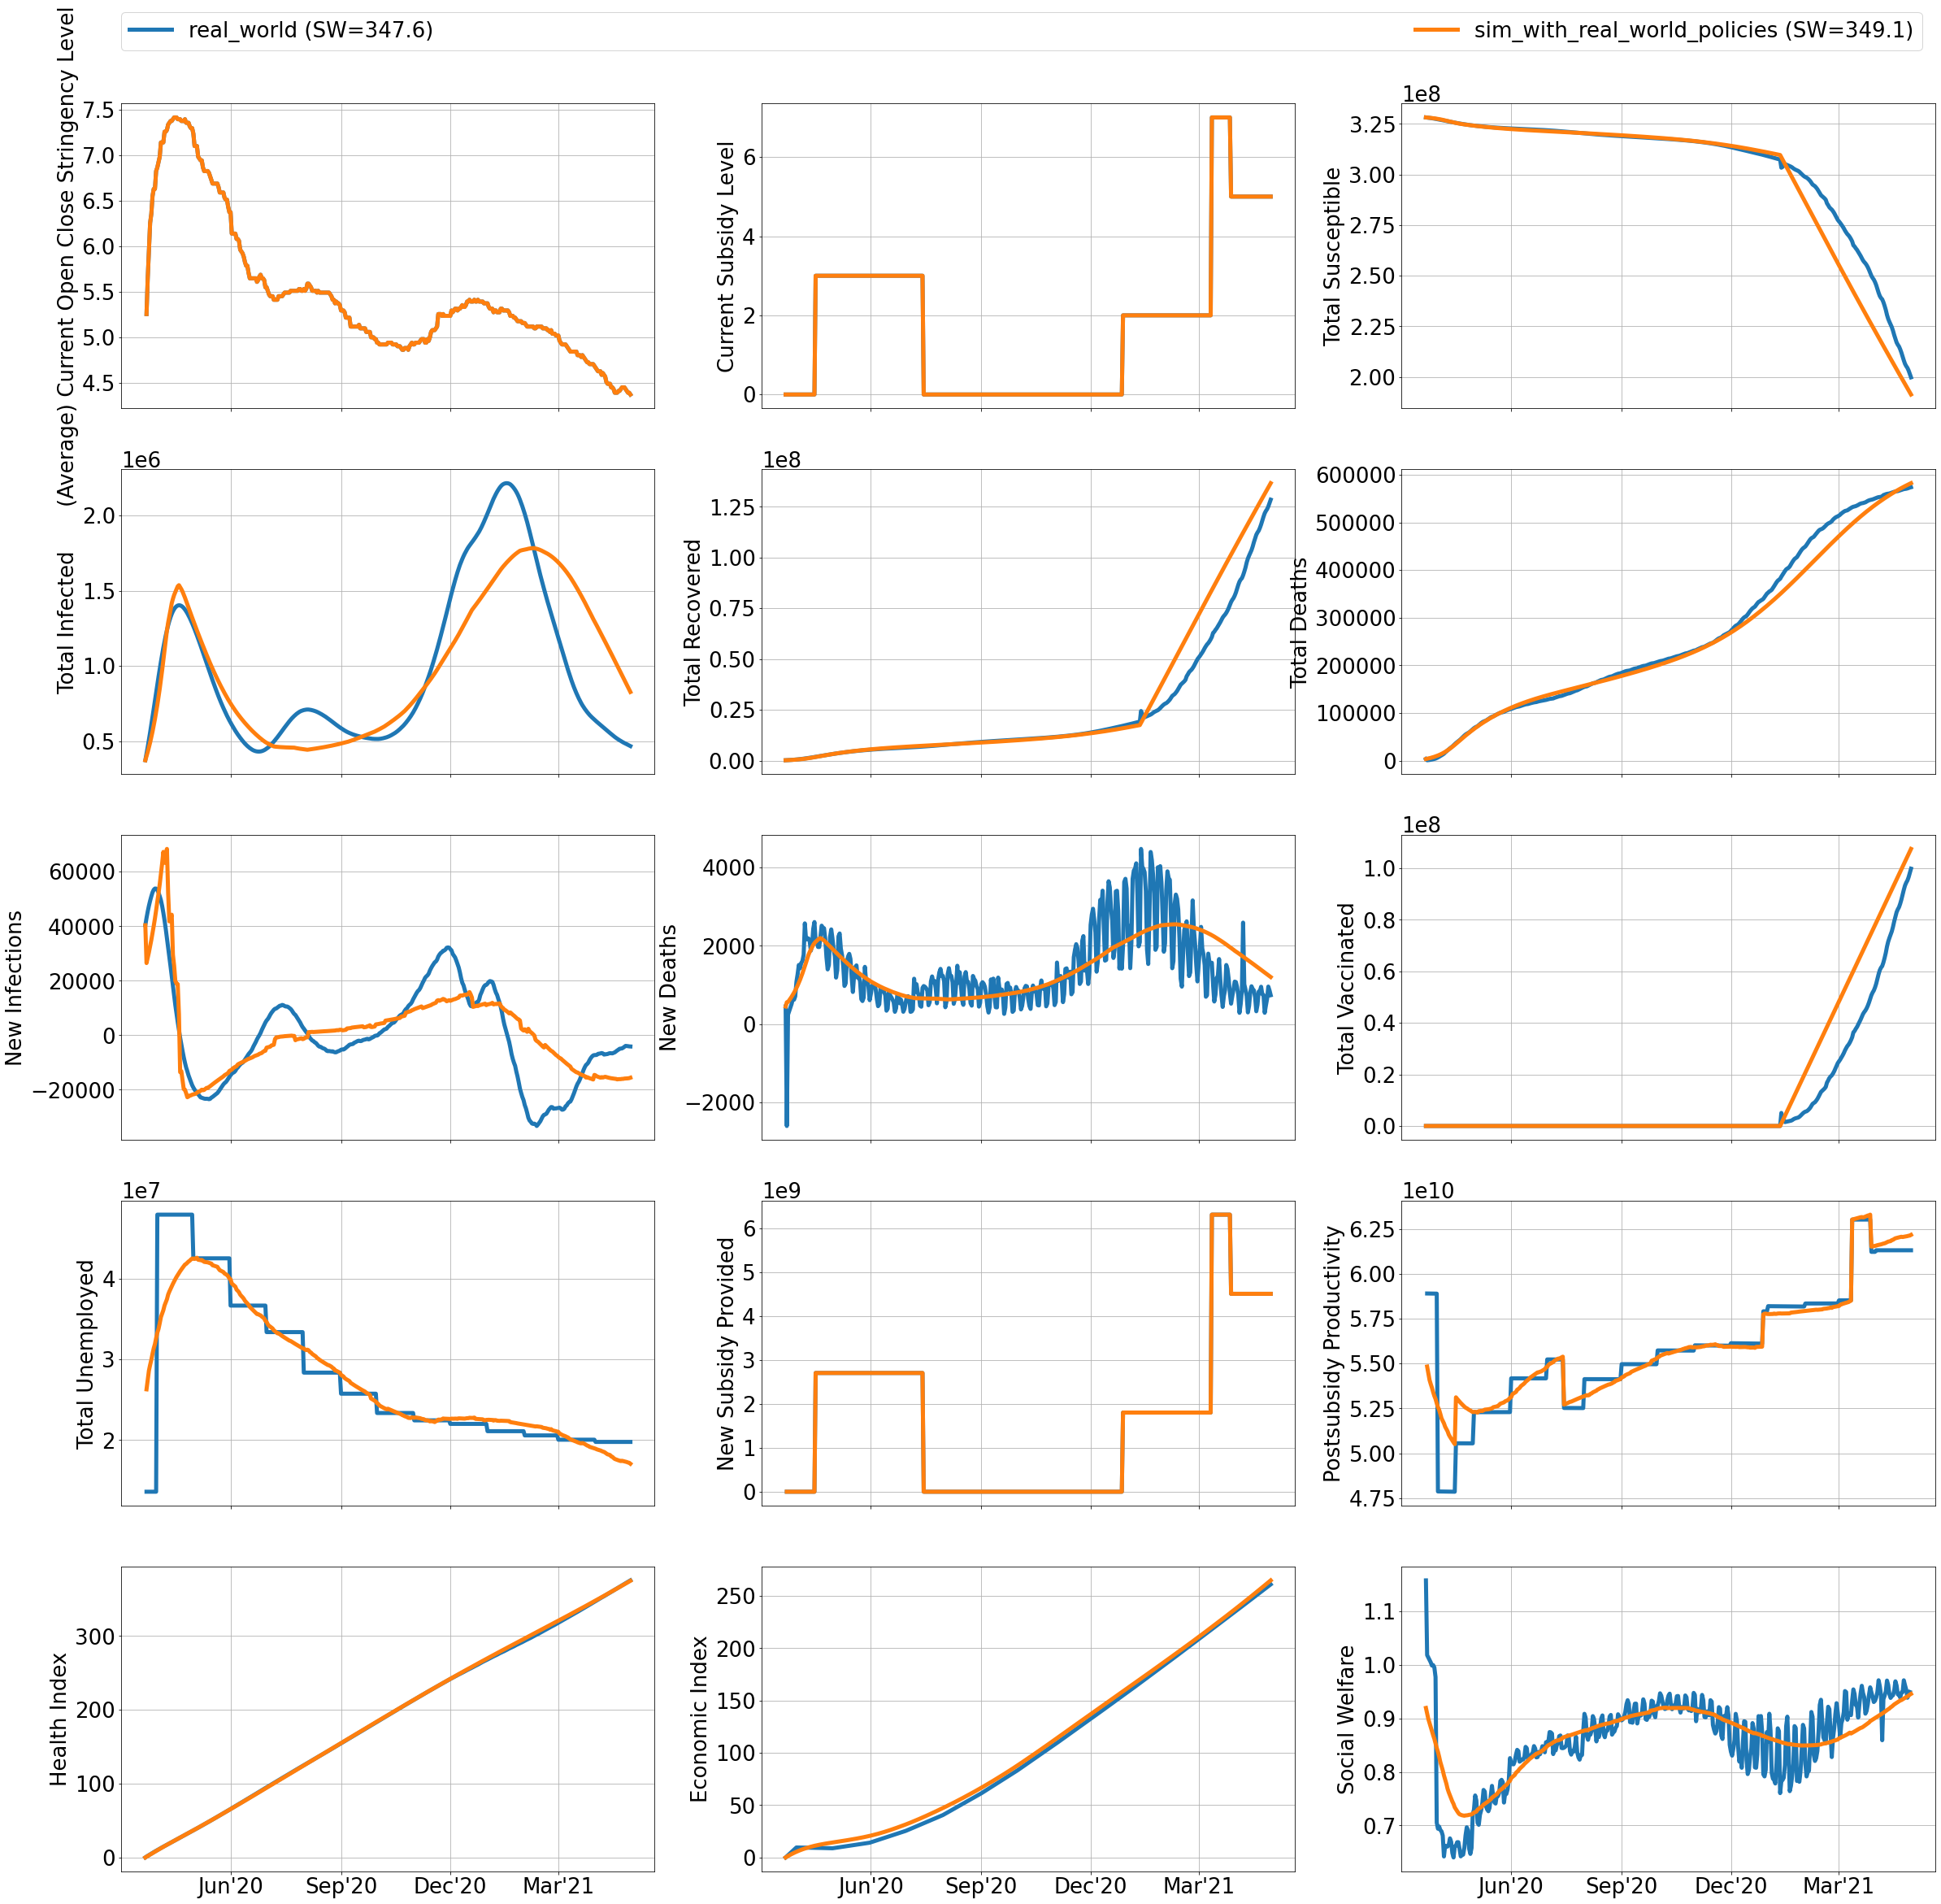

In [14]:
# Visualizing the environment states for the USA.
# You can set US state names to the entity keyword and visualize the state specific values as well ! 

visualize_states(
    entity="USA",
    dense_logs = dense_logs,
)

Comparing the curves for the real-world and the simulation with real-world policies, we see that we are able to fit the real-world data reasonably well.

We can also use this simulation to study the effect of any other (government) policy, for example,
- states open + no subsidies
- states closed + full subsidies
- states closed for two months (and open after) + no subsidies

## Scenario 3: states open + no subsidies

In [15]:
%%capture
# minimize print clutter

dense_logs["sim_with_states_open_no_subsidies"] = fetch_env_dense_log(
    env_config,
    action_type="states_open_no_subsidies"
)

## Scenario 4: states closed + full subsidies

In [16]:
%%capture
# minimize print clutter

dense_logs["sim_with_states_closed_full_subsidies"] = fetch_env_dense_log(
    env_config,
    action_type="states_closed_full_subsidies"
)

## Scenario 5: states closed for 6 months (and open after) + no subsidies

In [17]:
%%capture
# minimize print clutter

dense_logs["sim_with_states_closed_6_months_no_subsidies"] = fetch_env_dense_log(
    env_config,
    action_type="states_closed_6_months_no_subsidies"
)

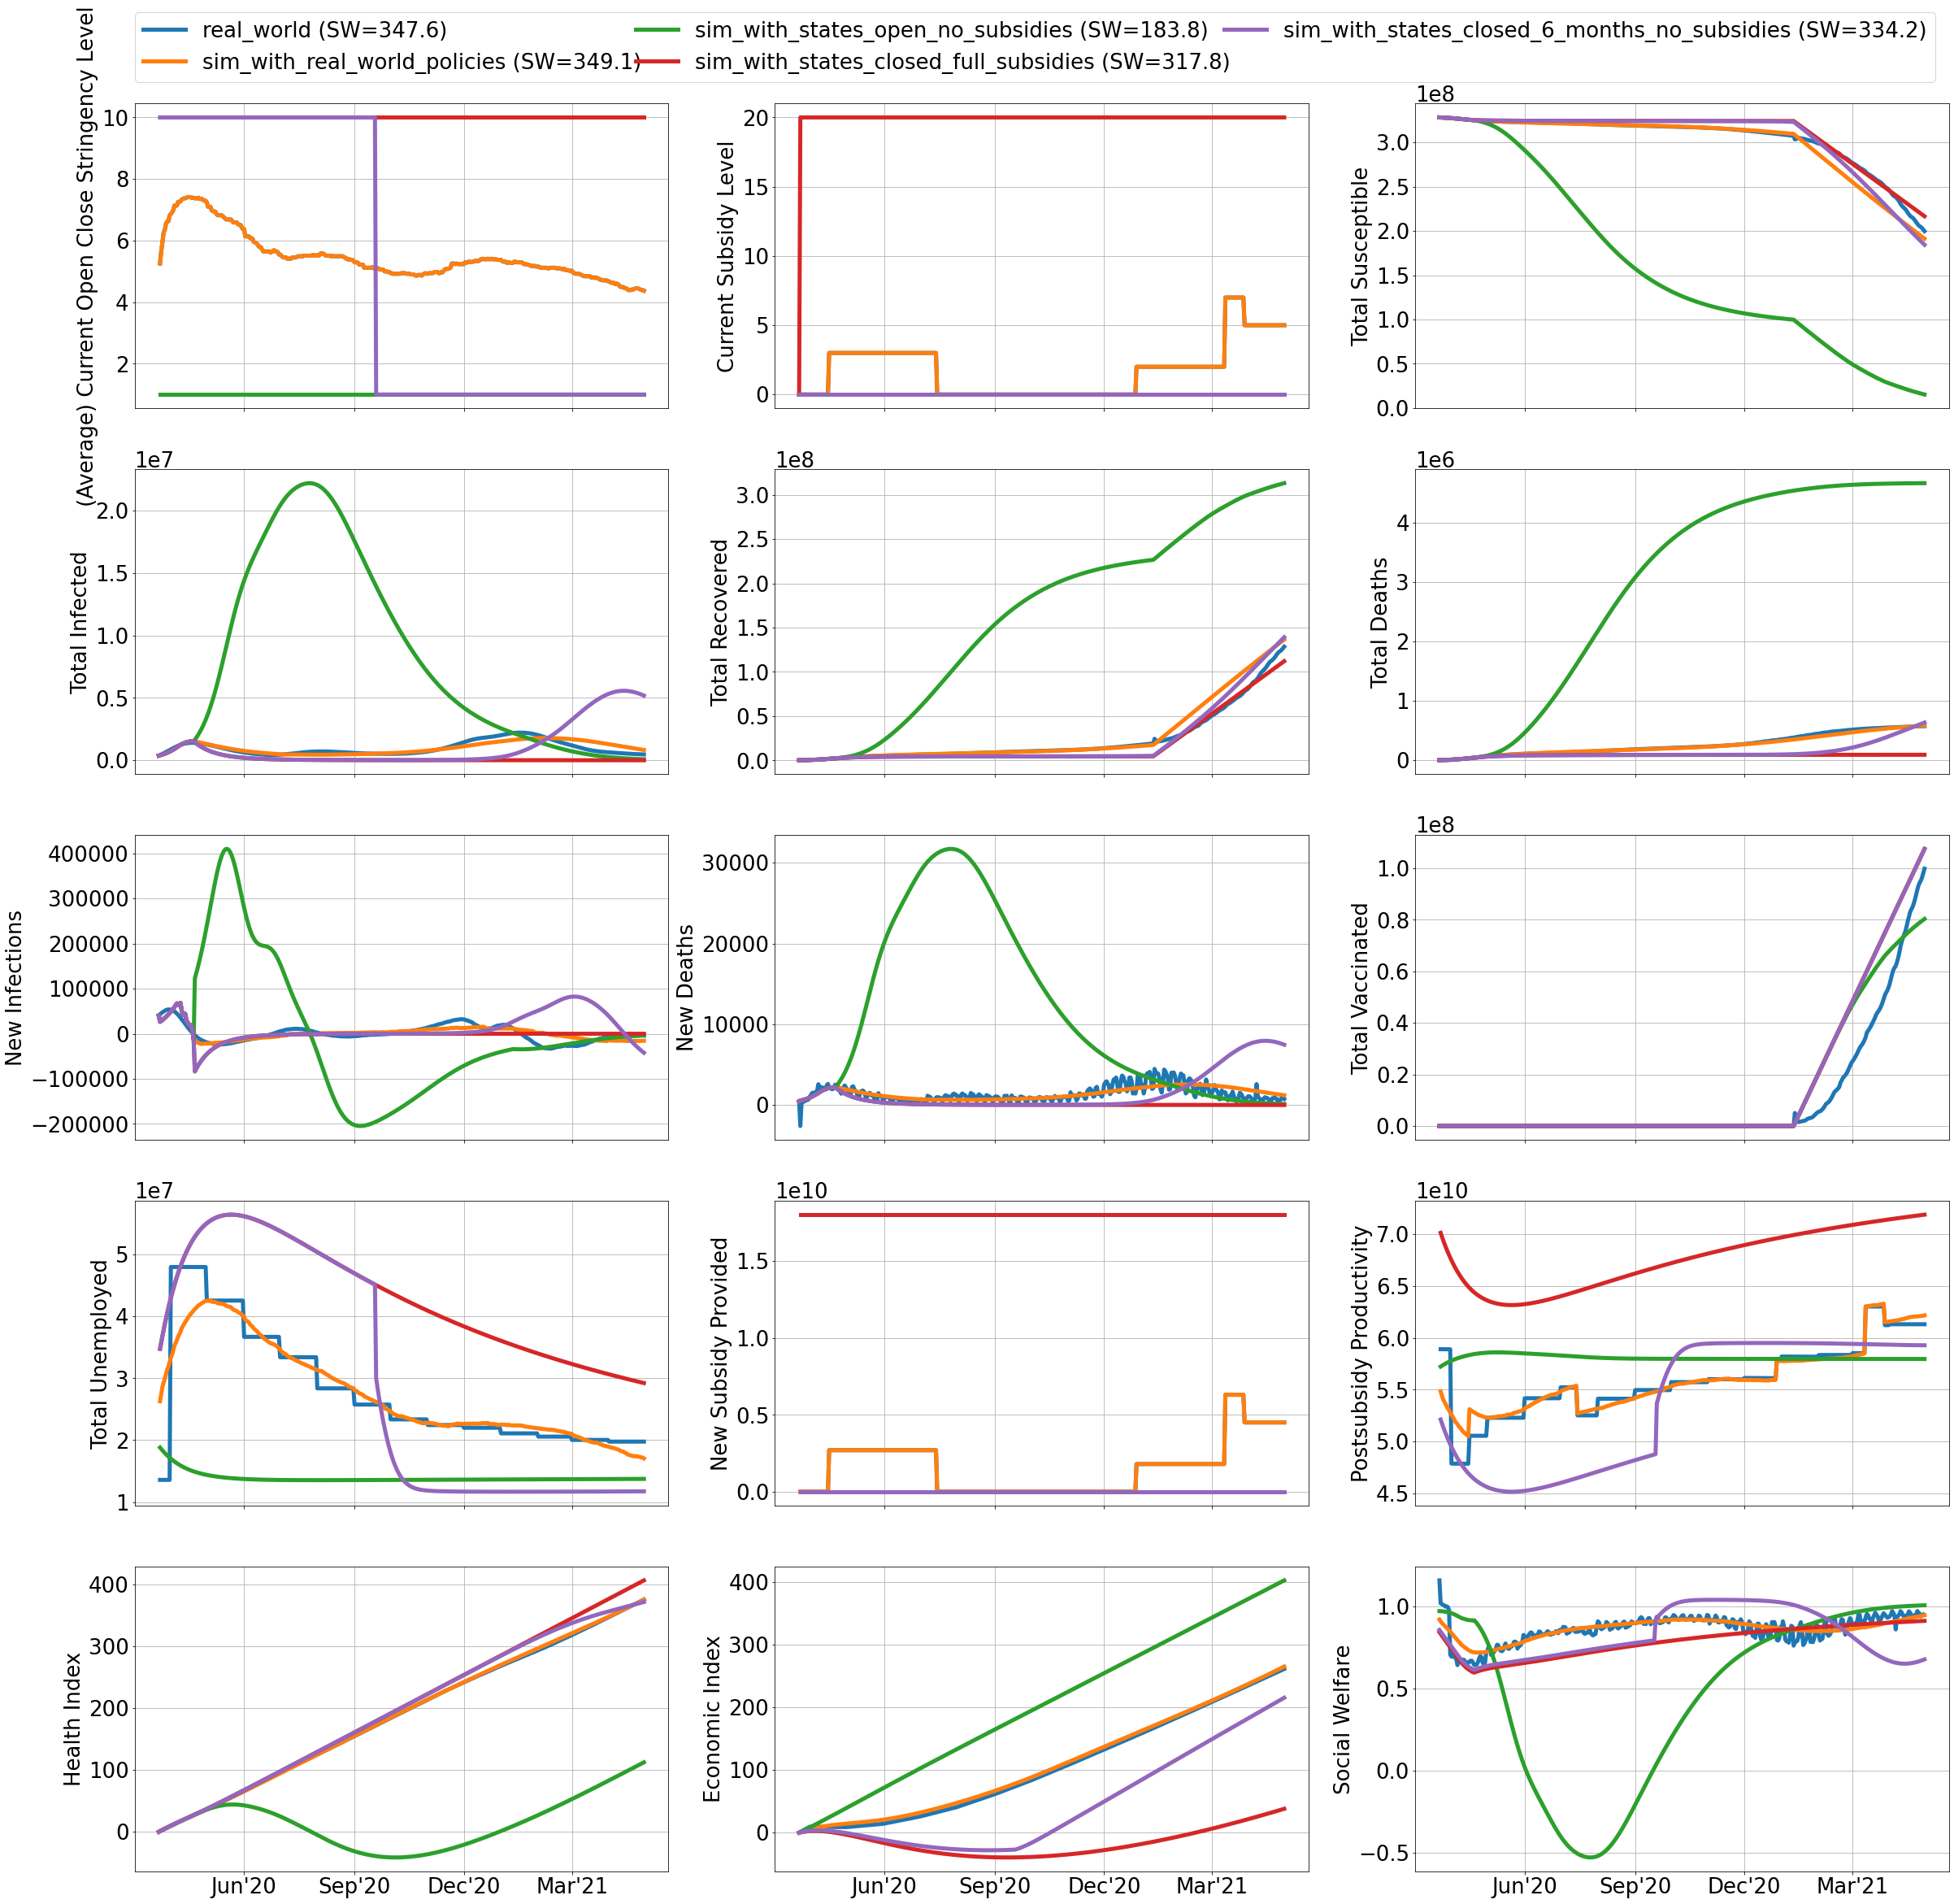

In [18]:
visualize_states(
    entity="USA",
    dense_logs = dense_logs,
)

It is evident that different government policies result in very different behaviors and result in varying values of social welfare (SW) (the SW numbers are shown in parentheses in the legend):\
Real-World: 347.6\
Simulation with real-world policies: 349.1\
Simulation with states open, and no subsidies: 183.8\
Simulation with states closed, and full subsidies: 317.8\
Simulation with states closed for 6 months and open after, and no subsidies: 334.2

Some of the key takeaways here are:
- Higher stringency results in fewer infections and deaths, but also increased unemployment. This leads to the highest health index, but the lowest economic index.
- Lower stringency results in exactly the opposite trend - the least unemployment, since everything is open, but also, leads to the highest deaths.
- Interestingly, note that the real-world policy (```'sim_with_real_world_policies'```) leads to the highest social welfare, so (according to our simulation) the real-world actions were better than these 3 simple alternatives!

We note that the welfare numbers provided here are for the USA (federal government). Feel free to play around with the ```entity``` argument in the cell above to visualize the curves for different states too.

# Varying social welfare objectives

Our simulation is also flexible to allow for any set of health and economic priority scalings / multipliers for the agents and the planner, resulting in varying social welfare functions. Note that these scalings multiply on top of the health and economic priorities inferred from the real data (for details, see this [notebook](https://github.com/salesforce/ai-economist/blob/master/ai_economist/datasets/covid19_datasets/fit_model_parameters.ipynb)).

We refer to the tuple $(m_a = 1, m_p = 1)$ as our base scenario, wherein the priority multipliers for both the agents (states) and the planner (the USA) is 1. Accordingly, $(m_a = 2, m_p = 1)$ means (all) the states prioritize health about twice as as the data would suggest, $(m_a = 0.5, m_p = 1)$ means the states prioritize *the economy* twice as much, and $(m_a = 1, m_p = 2)$ means the *federal government* prioritizes health twice as much.

Let us generate some dense logs with different health and economy priority scalings and compare them.

First, let's consider different agent priorities and visualize the social welfare for the simulation with the set of actions where the states are always open and the federal government does not subsidize.

In [ ]:
%%capture
# minimize print clutter

# Social welfare comparisons for the state of California

dense_logs = {}

for m_a, m_p in [
    (0.25, 1),
    (0.5, 1),
    (1, 1),    
    (2, 1),
    (4, 1)
]:
    print(f"\nRunning the simulation for priority {(m_a, m_p)}... \n")
    prioritized_env_config = env_config.copy()
    prioritized_env_config.update(
        {
            "health_priority_scaling_agents": m_a,
            "health_priority_scaling_planner": m_p
        }
    )
    dense_logs[f"$(m_a={m_a}, m_p={m_p})$"] = fetch_env_dense_log(
        prioritized_env_config,
        action_type="states_open_no_subsidies"
)

In [ ]:
visualize_states(
    entity="California",
    dense_logs = dense_logs,
    states = ["Social Welfare"]
)

Looking at the social welfare numbers, we see that when the states prioritize the health the least, the social welfare is the highest, and the social welfare decreases as the states choose to prioritize health more and more. This ties back to the "always open" actions taken by the states here, as in - when the states do not prioritize health over the economy, keeping them always open yields the best social welfare

Next, let's consider different planner priorities and visualize the social welfares for the simulation with the set of actions where the states are always closed and the federal government subsidizes the full (maximum) amount.

In [ ]:
%%capture
# minimize print clutter

dense_logs = {}

for m_a, m_p in [
    (1, 0.25),
    (1, 0.5),
    (1, 1),
    (1, 2),
    (1, 4),
]:
    print(f"\nRunning the simulation for priority {(m_a, m_p)}... \n")
    prioritized_env_config = env_config.copy()
    prioritized_env_config.update(
        {
            "health_priority_scaling_agents": m_a,
            "health_priority_scaling_planner": m_p
        }
    )
    dense_logs[f"$(m_a={m_a}, m_p={m_p})$"] = fetch_env_dense_log(
        prioritized_env_config,
        action_type="states_closed_full_subsidies"
)

In [ ]:
visualize_states(
    entity="USA",
    dense_logs = dense_logs,
    states = ["Social Welfare"]
)

The social welfare for the planner (when it subsidizes the full amount) is highest also when it prioritizes the economy the most, and least when it prioritizes the economy the least, understandably so.

In general, when states prioritize health, they like to shut down more , thus the health index improves at the cost of the economic index (due to increased unemployment from shutting down). When the federal government prioritizes health, it tends to spend more in subsidy to help states economically during shut downs (so they can afford to shut down more), which results in a higher health index. However, subsidy-driven shutdown has a high economic cost for the federal government. On the other hand, subsidies increase the state-level economic index. In our [paper](https://arxiv.org/abs/2108.02904), we use multi-agent reinforcement learning agent to optimize the state and federal government policies for several different social welfare objectives.

And that's it for this tutorial. Feel free to play around with the environment and visualize the effects for different entities, action types and health/economy priorities.